In [1]:
import keras
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, SeparableConv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, SpatialDropout2D, Flatten
from keras.models import Model
from keras import backend as K
from keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
%matplotlib inline

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Создание сверточного автокодировщика для данных Fashion MNIST

In [27]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [28]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [18]:
x_train.shape

(60000, 28, 28)

Проверка корректности загрузки датасета.

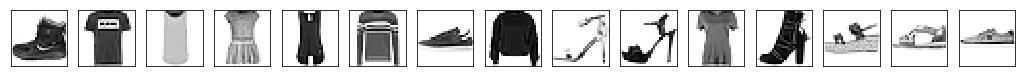

In [20]:
n = 15
plt.figure(figsize=(18,8))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i], cmap="Greys")    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Выделение набора для валидации.

In [33]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [34]:
x_valid = x_train[-10000:]
x_train = x_train[:-10000]
y_valid = y_train[-10000:]
y_train = y_train[:-10000]

Создание модели без регуляризации. Такая последовательность слоев с количеством нейронов показала лучший результат среди испытанных. Изначально сделал попытку натренировать сверточный классификатор и использовать его часть без выходного слоя как encoder (с замороженными весами). Оказалось, это привело к несколько худшему результату. Поэтому стал обучать обе части автокодировщика (encoder и decoder) одновременно.

In [22]:
keras.backend.clear_session()

inp = Input(shape=(28,28,1))
x = Conv2D(64, (3, 3), padding='same')(inp)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = ReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(inp, encoded)

encoder_inp = Input(shape=(28,28,1))
encoder_out = encoder(encoder_inp)
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(encoder_out)
x = ReLU()(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = ReLU()(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = ReLU()(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(encoder_inp, decoded)

#H = (H1 - 1)*stride + HF - 2*padding
#H - height of output image i.e H = 28 
#H1 - height of input image i.e H1 = 7 
#HF - height of filter 

#16 -> 28

In [24]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 4, 4, 256)         369664    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
__________

Поэкспериментировал с lr(1е-1 - 1e-4). 

In [25]:
opt = keras.optimizers.Adam(lr=1e-3, decay=1e-4, amsgrad=True)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

In [35]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=30, 
                                              verbose=0, 
                                              mode='auto', 
                                              restore_best_weights=True)
history = autoencoder.fit(x_train, x_train,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_valid, x_valid),
                  callbacks=[early_stopper]
                  )

Train on 30000 samples, validate on 10000 samples
Epoch 1/300
30000/30000 [==============================] - 28s 948us/step - loss: 0.3274 - val_loss: 0.2768
Epoch 2/300
30000/30000 [==============================] - 24s 794us/step - loss: 0.2716 - val_loss: 0.2667
Epoch 3/300
30000/30000 [==============================] - 24s 795us/step - loss: 0.2643 - val_loss: 0.2620
Epoch 4/300
30000/30000 [==============================] - 24s 796us/step - loss: 0.2607 - val_loss: 0.2592
Epoch 5/300
30000/30000 [==============================] - 24s 792us/step - loss: 0.2586 - val_loss: 0.2581
Epoch 6/300
30000/30000 [==============================] - 24s 794us/step - loss: 0.2571 - val_loss: 0.2559
Epoch 7/300
30000/30000 [==============================] - 24s 795us/step - loss: 0.2562 - val_loss: 0.2549
Epoch 8/300
30000/30000 [==============================] - 24s 795us/step - loss: 0.2553 - val_loss: 0.2543
Epoch 9/300
30000/30000 [==============================] - 24s 795us/step - loss: 0.25

Epoch 76/300
30000/30000 [==============================] - 24s 791us/step - loss: 0.2466 - val_loss: 0.2469
Epoch 77/300
30000/30000 [==============================] - 24s 791us/step - loss: 0.2465 - val_loss: 0.2468
Epoch 78/300
30000/30000 [==============================] - 24s 792us/step - loss: 0.2465 - val_loss: 0.2468
Epoch 79/300
30000/30000 [==============================] - 24s 791us/step - loss: 0.2465 - val_loss: 0.2468
Epoch 80/300
30000/30000 [==============================] - 24s 791us/step - loss: 0.2465 - val_loss: 0.2467
Epoch 81/300
30000/30000 [==============================] - 24s 791us/step - loss: 0.2464 - val_loss: 0.2467
Epoch 82/300
30000/30000 [==============================] - 24s 791us/step - loss: 0.2464 - val_loss: 0.2467
Epoch 83/300
30000/30000 [==============================] - 24s 790us/step - loss: 0.2464 - val_loss: 0.2467


В целом, ошибка снижается довольно плавно.

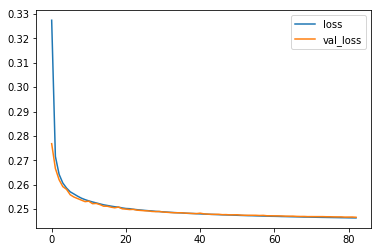

In [36]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [37]:
autoencoder.save_weights("autoencoder_weights.h5")

In [38]:
decoded_imgs = autoencoder.predict(x_test)

In [39]:
decoded_imgs = decoded_imgs.reshape(-1, 28, 28)
decoded_imgs.shape

(10000, 28, 28)

Вывод результата работы автокодировщика на тестовом сете. Картинки довольно размыты.

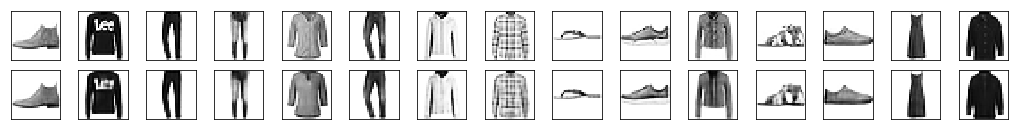

In [40]:
n = 15
plt.figure(figsize=(18,2))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="Greys")    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i], cmap="Greys")    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Создание автокодировщика с нормализацией.

In [41]:
keras.backend.clear_session()

inp = Input(shape=(28,28,1))
x = Conv2D(64, (3, 3), padding='same')(inp)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization(center=False, scale=False)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization(center=False, scale=False)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(inp, encoded)

encoder_inp = Input(shape=(28,28,1))
encoder_out = encoder(encoder_inp)
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(encoder_out)
x = ReLU()(x)
x = BatchNormalization(center=False, scale=False)(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization(center=False, scale=False)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization(center=False, scale=False)(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = ReLU()(x)
x = BatchNormalization(center=False, scale=False)(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(encoder_inp, decoded)

In [42]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 4, 4, 256)         370432    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 256)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16, 16, 128)       0         
__________

In [43]:
opt = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

In [44]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=30, 
                                              verbose=0, 
                                              mode='auto', 
                                              restore_best_weights=True)
history = autoencoder.fit(x_train, x_train,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_valid, x_valid),
                  callbacks=[early_stopper]
                  )

Train on 30000 samples, validate on 10000 samples
Epoch 1/300
30000/30000 [==============================] - 28s 941us/step - loss: 0.2923 - val_loss: 0.2678
Epoch 2/300
30000/30000 [==============================] - 27s 915us/step - loss: 0.2604 - val_loss: 0.2580
Epoch 3/300
30000/30000 [==============================] - 27s 909us/step - loss: 0.2563 - val_loss: 0.2569
Epoch 4/300
30000/30000 [==============================] - 27s 902us/step - loss: 0.2546 - val_loss: 0.2588
Epoch 5/300
30000/30000 [==============================] - 27s 902us/step - loss: 0.2530 - val_loss: 0.2526
Epoch 6/300
30000/30000 [==============================] - 27s 902us/step - loss: 0.2522 - val_loss: 0.2538
Epoch 7/300
30000/30000 [==============================] - 27s 902us/step - loss: 0.2511 - val_loss: 0.2517
Epoch 8/300
30000/30000 [==============================] - 27s 902us/step - loss: 0.2506 - val_loss: 0.2506
Epoch 9/300
30000/30000 [==============================] - 27s 902us/step - loss: 0.25

Здесь плавный график ошибки на тренировке, но на валидации вырос разброс. Под конец обучения ошибка ниже, чем в случае без регуляризации.

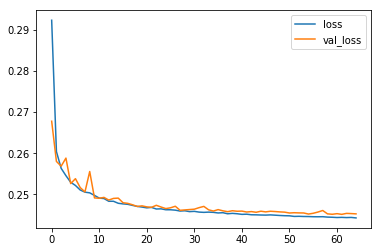

In [45]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [47]:
autoencoder.save_weights("autoencoder_reg_weights.h5")

Результат теста. Здесь вроде изображения более четкие.

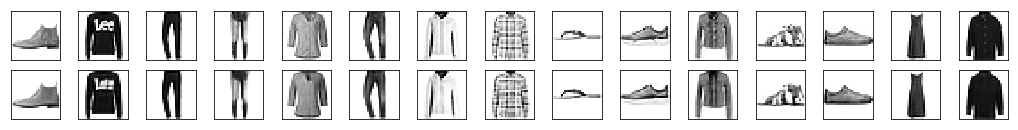

In [46]:
decoded_imgs = autoencoder.predict(x_test)

n = 15
plt.figure(figsize=(18,2))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="Greys")    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()